# ECG study case #

In [1]:
# Modules
import requests
import websocket
import time
from datetime import datetime
import pandas as pd
import threading
import yaml
import numpy as np

# Modules for visualization 
import bokeh
from bokeh.models import ColumnDataSource
from bokeh.io import curdoc
from bokeh.plotting import figure
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Modules for statistical analysis
import neurokit2 as nk
from statsmodels.graphics.tsaplots import plot_acf
import ruptures as rpt

%matplotlib notebook 

## Part I: a working client for streaming data ##

In [6]:
# WebSocket server URL
ws_url = "ws://assemblix:8383"

# Empty lists to store data
ecg = [] # ECG I (mV)
ecg_f = [] # ECG I filtered (mV)
time = [] # Time (ms)

### WebSocket ###

Functions to handle WebSocket and message

In [7]:
# Function to handle received data
def on_message(ws, message):
    '''
    Split message, convert the data type and add to the target list
    '''
        
    data = message.split(',')
    print (data)
    try:
        time_ms = datetime.strptime(data[0].split()[2], '%H:%M:%S.%f')
        ecg_mv = float(data[1])
        ecg_mvf = float(data[2])
    except:
        print (f'{message} could not be parsed')

    # Append the received values to the data lists
    time.append(time_ms)
    ecg.append(ecg_mv)
    ecg_f.append(ecg_mvf)
            
# Function to handle WebSocket open
def on_open(ws):
    print("Connected to WebSocket server")

# Function to handle WebSocket close
def on_close(ws):
    print("Connection to WebSocket server closed")

# WebSocket connection
def run_websocket():
    ws = websocket.WebSocketApp(ws_url,
                                on_message=on_message,
                                on_open=on_open,
                                on_close=on_close)
    ws.run_forever()

# Function to update the plot
def update(frame):
    '''Update plot whenever we receive new messages'''
    
    # Clear previous plot
    plt.cla()
    
    # Plot the data
    plt.plot(time, ecg_f, label='ECG I')
    plt.plot(time, ecg, label='ECG I filtered')
    plt.ylim(-0.3, 1)
    
    # Title and labels of the plot
    plt.title('ECG Plot')
    plt.xlabel('Time (ms)')
    plt.ylabel('ECG (mV)')
    plt.legend(loc='best')

### Connect to WebSocket ###

In [ ]:
# Start WebSocket connection in a separate thread
websocket_thread = threading.Thread(target=run_websocket)
websocket_thread.start()

# Initiate a plot
fig, ax = plt.subplots()

# Create an animation to update the plot
ani = FuncAnimation(fig, update, interval=1000) # Update plot every 1000 milliseconds (1 second)

# Show the plot
plt.show()

<IPython.core.display.Javascript object>

/tmp/ipykernel_3262322/1035780535.py:9: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, interval=1000) # Update plot every 1000 milliseconds (1 second)
/homes/rmeshita/Desktop/Programming-3/assignment-1/assignment1/lib/python3.11/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


Connected to WebSocket server
['', 'ECG I', 'ECG I filtered']
,ECG I,ECG I filtered could not be parsed
['0 days 00:00:00', '-0.085', '-0.115']
0 days 00:00:00,-0.085,-0.115 could not be parsed


['0 days 00:00:00.002000', '-0.08', '-0.115']
['0 days 00:00:00.004000', '-0.07', '-0.12']
['0 days 00:00:00.006000', '-0.075', '-0.12']
['0 days 00:00:00.008000', '-0.095', '-0.12']
['0 days 00:00:00.010000', '-0.09', '-0.12']
['0 days 00:00:00.012000', '-0.1', '-0.12']
['0 days 00:00:00.014000', '-0.1', '-0.115']
['0 days 00:00:00.016000', '-0.1', '-0.115']
['0 days 00:00:00.018000', '-0.085', '-0.115']
['0 days 00:00:00.020000', '-0.06', '-0.11']
['0 days 00:00:00.022000', '-0.045', '-0.11']
['0 days 00:00:00.024000', '-0.055', '-0.11']
['0 days 00:00:00.026000', '-0.06', '-0.11']
['0 days 00:00:00.028000', '-0.07', '-0.105']
['0 days 00:00:00.030000', '-0.08', '-0.105']
['0 days 00:00:00.032000', '-0.085', '-0.105']
['0 days 00:00:00.034000', '-0.08', '-0.105']
['0 days 00:00:00.036000', '-0.07', '-0.1']
['0 days 00:00:00.038000', '-0.04', '-0.1']
['0 days 00:00:00.040000', '-0.05', '-0.1']
['0 days 00:00:00.042000', '-0.045', '-0.1']
['0 days 00:00:00.044000', '-0.04', '-0.1']
['0

Finally we have ECG I data, both raw and filtered, for 6 seconds. Use the ECG I filtered data for further analysis, for the raw data and contain both high and low-frequency noise components. (Lugovaya, 2005.)

## Part II: Extract features and perform analysis ##

### Apply neurokit2 to find out the features and conduct analysis. ###

In [10]:
# Convert list of filtered ECG signal to array
# Functions in neurokit2 need array, not list
ecg_filtered = np.array(ecg_f)

In [ ]:
# Find R peaks
# Chech if we can identify each cardiac cycle 
_, rpeaks = nk.ecg_peaks(ecg_filtered, sampling_rate=1000)

Text(0.5, 1.0, 'ECG I plot')

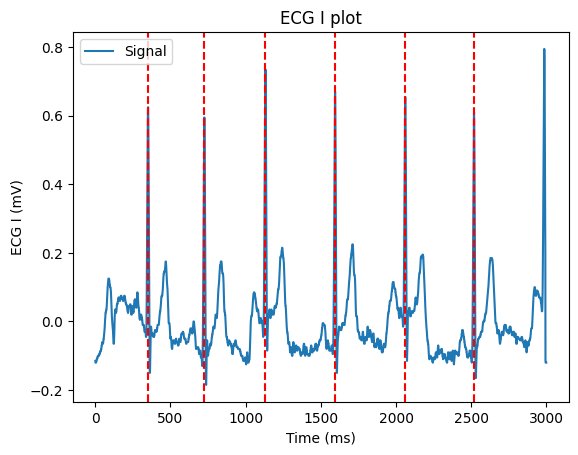

In [ ]:
# Zooming into the R-peaks
plot = nk.events_plot(rpeaks['ECG_R_Peaks'][:6], ecg_filtered[:3000])
plt.xlabel("Time (ms)")
plt.ylabel('ECG I (mV)')
plt.title("ECG I plot")

R-peaks location are correctly identified.

In [12]:
# Delineate the ECG signal
_, waves_peak = nk.ecg_delineate(ecg_filtered, rpeaks, sampling_rate=500, method="peak")

NameError: name 'rpeaks' is not defined

In [ ]:
# Zooming into the first 2 R-peaks, with focus on P_peaks, Q-peaks, S-peaks and T-peaks
# See more details of the data to find out the features
# 0: P peaks, 1: Q peaks, 2: S peaks, 3: T peaks
plot = nk.events_plot([waves_peak['ECG_T_Peaks'][:2], 
                       waves_peak['ECG_P_Peaks'][:2],
                       waves_peak['ECG_Q_Peaks'][:2],
                       waves_peak['ECG_S_Peaks'][:2]], ecg_filtered[:1000])
plt.xlabel("Time (ms)")
plt.ylabel('ECG I (mV)')
plt.title("ECG I plot")

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'ECG I plot')

T_peaks, P-peaks, Q-peaks and S-peaks are correctly identified (looks like).

In [ ]:
# Delineate the ECG signal and visualizing all peaks of ECG complexes
# Compare waves of different cardiac cycles
_, waves_peak = nk.ecg_delineate(ecg_filtered, 
                                 rpeaks, 
                                 sampling_rate=500, 
                                 method="peak",
                                 show=True, 
                                 show_type='peaks')
plt.xlabel("Time (ms)")
plt.ylabel('ECG I (mV)')
plt.title("ECG I plot")

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'ECG I plot')

Locations of the p peaks are more consistent, and there're higher values of all peaks in 3 cardiac cycle, compared to the other two.

### Autocorrelation ###

In [13]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(ecg_f, ax=ax, lags=2993)
plt.plot(ecg_f, label='ECG I filtered')
plt.title('Autocorrelation of ECG I')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend(loc='best')

# Add a text annotation below the plot
plt.text(-0.75, -0.9,
         'Shaded area is 95% confidence interval, correlation values outside of this are significant',
         wrap=False, fontsize=10, color='white')

plt.show()

<IPython.core.display.Javascript object>

From 1000 ms, this ECG I data is significantly autocorrelated.

In [14]:
ecg_data_reshaped = ecg_filtered.reshape(-1, 1)

# Define the model
model = "linear"  # For detecting gradual changes or trends in the data.
algo = rpt.Binseg(model=model).fit(ecg_data_reshaped)

# Predict change points
result = algo.predict(n_bkps=2)
   
# Display
rpt.display(ecg_filtered, [0] + result, figsize=(9, 5), label=False)
plt.title('Change Point Detection in ECG Signal')

# Create lines for changing points
for x in result:
    if x != result[-1]:
        plt.axvline(x=x, color='w', linestyle='--', label=f"{x}ms")
    
# Add a text annotation below the plot
plt.text(500, 0.78,
         f'change points: {result[:-1]} ms',
         wrap=False, fontsize=10, color='white')

plt.show()

<IPython.core.display.Javascript object>

The change points are in 345 and 1645 ms.